In [237]:
import os
import json
import pprint
import pandas as pd
import seaborn as sns
import pylab as pl
import numpy as np
%matplotlib inline

from pipeline.python.utils import natural_keys, replace_root

from pipeline.python.visualization import plot_psths_from_dataframe as psth
from pipeline.python.traces.utils import load_TID, get_metric_set
from pipeline.python.paradigm.align_acquisition_events import get_stimulus_configs, set_pupil_params


In [25]:
pp = pprint.PrettyPrinter(indent=4)


rootdir = '/mnt/odyssey'
animalid = 'CE074'
session = '20180215'
acquisition = 'FOV2_zoom1x_LI'
run= 'blobs'
trace_id = 'traces006'
filter_pupil = True

In [26]:
pupil_radius_min = 30
pupil_radius_max = 40
pupil_dist_thr = 4

In [12]:
run_dir = os.path.join(rootdir, animalid, session, acquisition, run)

# Load TRACE ID info:
# =========================================================================
TID = load_TID(run_dir, trace_id)
traceid_dir = TID['DST']
if rootdir not in traceid_dir:
    orig_root = traceid_dir.split('/%s/%s' % (animalid, session))[0]
    traceid_dir = traceid_dir.replace(orig_root, rootdir)
    print "Replacing orig root with dir:", traceid_dir
    #trace_hash = TID['trace_hash']

USING TRACE ID: traces006
{   u'DST': u'/n/coxfs01/2p-data/CE074/20180215/FOV2_zoom1x_LI/blobs/traces/traces006_63095e',
    u'PARAMS': {   u'excluded_tiffs': [],
                   u'hashid': u'796577',
                   u'nonnegative': False,
                   u'rid_hash': u'93d85c',
                   u'roi_id': u'rois025',
                   u'roi_type': u'manual2D_warp',
                   u'signal_channel': 1,
                   u'tiff_source': u'/n/coxfs01/2p-data/CE074/20180215/FOV2_zoom1x_LI/blobs/processed/processed001_7cb339/mcorrected_7f4625_uint16',
                   u'uint16': True,
                   u'unsigned': False},
    u'SRC': u'/n/coxfs01/2p-data/CE074/20180215/FOV2_zoom1x_LI/blobs/processed/processed001_7cb339/mcorrected_7f4625_uint16',
    u'trace_hash': u'63095e',
    u'trace_id': u'traces006',
    u'version': u'0.1.0'}
Replacing orig root with dir: /mnt/odyssey/CE074/20180215/FOV2_zoom1x_LI/blobs/traces/traces006_63095e


In [18]:
event_info_fpath = [os.path.join(traceid_dir, f) for f in os.listdir(traceid_dir) if 'event_alignment' in f and f.endswith('json')][0]
with open(event_info_fpath, 'r') as f:
    trial_info = json.load(f)
if rootdir not in trial_info['parsed_trials_source']:
    trial_info['parsed_trials_source'] = replace_root(trial_info['parsed_trials_source'], rootdir, animalid, session)
configs, stimtype = get_stimulus_configs(trial_info)


ORIG ROOT: /mnt/odyssey/CE074/20180215/FOV2_zoom1x_LI/blobs/paradigm/trials_22a6ca.json
NEW ROOT: /mnt/odyssey/CE074/20180215/FOV2_zoom1x_LI/blobs/paradigm/trials_22a6ca.json
---> Found 9 unique stimulus configs.


In [27]:
# Load particular metrics set:
selected_metric = get_metric_set(traceid_dir, filter_pupil=filter_pupil,
                                     pupil_radius_min=pupil_radius_min,
                                     pupil_radius_max=pupil_radius_max,
                                     pupil_dist_thr=pupil_dist_thr
                                     )

# Load associated pupil_params set:
with open(os.path.join(traceid_dir, 'metrics', selected_metric, 'pupil_params.json'), 'r') as f:
    pupil_params = json.load(f)
pp.pprint(pupil_params)

Selected metric: pupil_rmin30.00-rmax40.00-dist4.00_16571566995474823667
Use?  Press <Y> to confirm, <n> to reset: Y
{   u'dist_thr': 4.0,
    u'hash': 16571566995474823667L,
    u'max_nblinks': 0,
    u'radius_max': 40.0,
    u'radius_min': 30.0}


In [30]:
# Set paths toi ROIDATA_, roi_metrics_, and roi_stats_:
trace_type = 'np_corrected_fissa'
roistats_filepath = [os.path.join(traceid_dir, 'metrics', selected_metric, f)
                        for f in os.listdir(os.path.join(traceid_dir, 'metrics', selected_metric))
                        if 'roi_stats_' in f  and trace_type in f and f.endswith('hdf5')][0]

roidata_filepath = [os.path.join(traceid_dir, f)
                        for f in os.listdir(traceid_dir)
                        if 'ROIDATA_' in f and trace_type in f and f.endswith('hdf5')][0]


### Plot PSTH

In [221]:
pupil_max_nblinks = pupil_params['max_nblinks']
pupil_radius_min = 30 #float(pupil_params['radius_min'])
pupil_radius_max = 50 #float(pupil_params['radius_max'])
#pupil_size_thr = pupil_params['size_thr']
pupil_dist_thr = float(pupil_params['dist_thr'])


In [222]:
DATA = pd.HDFStore(roidata_filepath, 'r')


In [223]:
transform_dict, object_transformations = psth.get_object_transforms(DATA[DATA.keys()[0]])


#### Get subset of ROIDATA dataframe for specific ROI:

In [224]:
roi = 'roi00041'

DF = DATA[roi] #[DATA[roi]['config'].isin(curr_subplots)]
DF['position'] = list(zip(DF['xpos'], DF['ypos']))

curr_slice = list(set(DF['slice']))[0] #roi_trials[configname][roi].attrs['slice']
roi_in_slice = list(set(DF['roi_in_slice']))[0] #roi_trials[configname][roi].attrs['idx_in_slice']

    # Plot df values:
if filter_pupil is True:
    filtered_DF = DF.query('pupil_size_stimulus > @pupil_radius_min \
                           & pupil_size_baseline > @pupil_radius_min \
                           & pupil_size_stimulus < @pupil_radius_max \
                           & pupil_size_baseline < @pupil_radius_max \
                           & pupil_dist_stimulus < @pupil_dist_thr \
                           & pupil_dist_baseline < @pupil_dist_thr \
                           & pupil_nblinks_stim <= @pupil_max_nblinks \
                           & pupil_nblinks_baseline >= @pupil_max_nblinks')

pass_trials = list(set(filtered_DF['trial']))
print len(pass_trials)

excluded_DF = DF[~DF['trial'].isin(pass_trials)]

#### Get stimulus info

In [229]:
# get current object iD:
object_list = list(set(DF['object']))
print "objects:", object_list

stimtype = 'image'

trans_types = object_transformations.keys()

[u'Blob_N1', u'Blob_N2', u'morph16', u'morph11', u'morph6']

#### Plot standard PSTH plots with all configs on subplots:

In [228]:
ordered_rows = sorted(list(set(DF['morphlevel'])))
ordered_cols = sorted(list(set(DF['yrot'])))
rows = 'morphlevel'
columns = 'yrot'

#draw_psth(roi, currdf, rows, columns, ordered_rows, ordered_cols, trace_color, stimbar_color, figpath)
row_order = ordered_rows
col_order = ordered_cols
trace_color = 'k'
stimbar_color = 'r'

Text(0.5,0.98,u'roi00041')

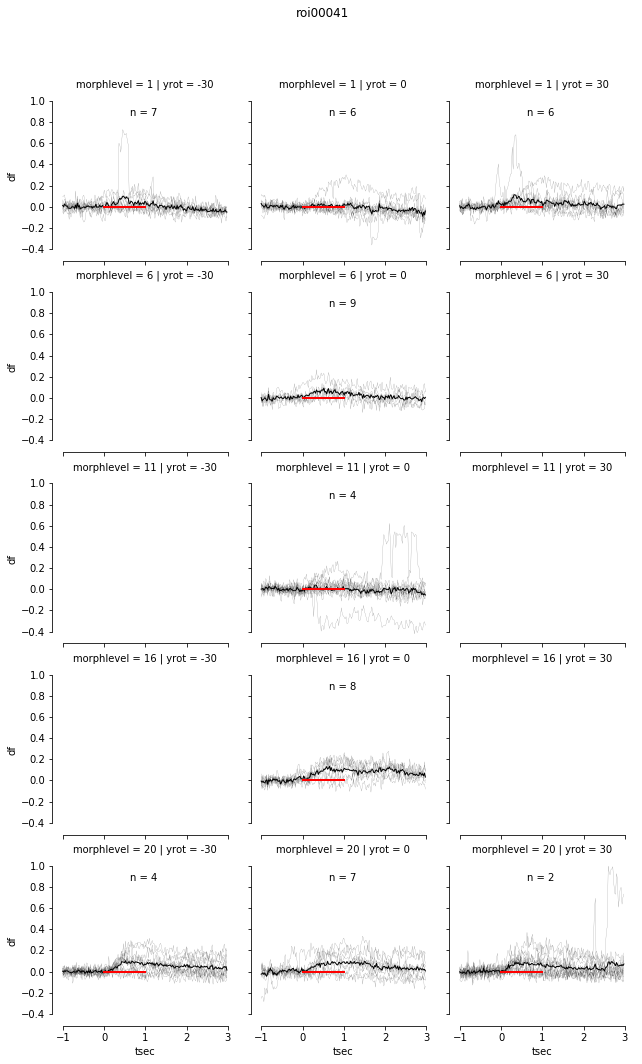

In [236]:
config_list = list(set(DF['config']))
# Add n trials to each subplot:
ntrials = dict((c, len(list(set(filtered_DF[filtered_DF['config']==c]['trial'])))) for c in config_list)

first_on = list(set(DF['first_on']))[0]
nsecs_on = list(set(DF['nsecs_on']))[0]
tsecs = sorted(list(set(DF['tsec'])))

#g1 = sns.FacetGrid(filtered_DF, row=rows, col=columns, sharex=True, sharey=True, hue='trial', row_order=row_order, col_order=col_order)
g1 = sns.FacetGrid(excluded_DF, row=rows, col=columns, sharex=True, sharey=True, hue='trial', row_order=row_order, col_order=col_order)
g1.map(pl.plot, "tsec", "df", linewidth=0.2, color=trace_color, alpha=0.5)
plotstats = psth.get_facet_stats(DF, config_list, g1)

# Get mean trace:
meandfs = {}
for config in plotstats['dfmats'].keys():
    meandfs[config] = np.mean(plotstats['dfmats'][config], axis=0)
    currax = g1.facet_axis(plotstats['indices'][config][0], plotstats['indices'][config][1])
    currax.plot(tsecs, meandfs[config], trace_color, linewidth=1, alpha=1)
    currax.plot([tsecs[first_on], tsecs[first_on]+nsecs_on], [0, 0], stimbar_color, linewidth=2, alpha=1)
    currax.annotate("n = %i" % ntrials[config], xy=psth.get_axis_limits(currax, xscale=0.2, yscale=0.8))

sns.despine(offset=2, trim=True)
#%
pl.subplots_adjust(top=0.9)
g1.fig.suptitle(roi)

### Filter trials manually:

In [1243]:
pupil_max_nblinks = pupil_params['max_nblinks']
pupil_radius_min = 25 #float(pupil_params['radius_min'])
pupil_radius_max = 65 #float(pupil_params['radius_max'])
#pupil_size_thr = pupil_params['size_thr']
pupil_dist_thr = 8 #float(pupil_params['dist_thr'])

In [1463]:
# roi = 'roi00009'
roi = 'roi00041'
# roi = 'roi00026'

filter_pupil = True

DF = DATA[roi] #[DATA[roi]['config'].isin(curr_subplots)]
DF = DF[DF['yrot']==0]

#DF['position'] = list(zip(DF['xpos'], DF['ypos']))
#mrph_df = filtered_DF[filtered_DF['yrot']==0]


curr_slice = list(set(DF['slice']))[0] #roi_trials[configname][roi].attrs['slice']
roi_in_slice = list(set(DF['roi_in_slice']))[0] #roi_trials[configname][roi].attrs['idx_in_slice']

    # Plot df values:
if filter_pupil is True:
    filtered_DF = DF.query('pupil_size_stimulus > @pupil_radius_min \
                           & pupil_size_baseline > @pupil_radius_min \
                           & pupil_size_stimulus < @pupil_radius_max \
                           & pupil_size_baseline < @pupil_radius_max \
                           & pupil_dist_stimulus < @pupil_dist_thr \
                           & pupil_dist_baseline < @pupil_dist_thr \
                           & pupil_nblinks_stim <= @pupil_max_nblinks \
                           & pupil_nblinks_baseline >= @pupil_max_nblinks')

#### Get morph trials only:

In [1464]:
#mrph_df = filtered_DF[filtered_DF['yrot']==0]
# morph_df = DF[DF['yrot']==0]

morph_trials = list(set(DF['trial']))
print len(morph_trials)

77


In [1465]:
filtered = {}
excluded= {}
morph_levels = list(set(DF['morphlevel']))
for mlevel in morph_levels:
    all_trials = list(set(DF[DF['morphlevel']==mlevel]['trial']))
    filtered_trials = list(set(filtered_DF[filtered_DF['morphlevel']==mlevel]['trial']))
    filtered['morph%i' % mlevel] = filtered_trials
    excluded['morph%i' % mlevel] = [t for t in all_trials if t not in filtered_trials]

In [1466]:
DF[DF['trial']=='trial00001']
excluded['morph16']

[u'trial00134', u'trial00038']

In [1467]:
curr_configs = list(set(DF[DF['yrot']==0]['config']))
morph_configs = dict((config, list(set(DF[DF['config']==config]['morphlevel']))[0]) for config in curr_configs)
pp.pprint(morph_configs)

{   u'config001': 20,
    u'config003': 1,
    u'config004': 11,
    u'config006': 16,
    u'config008': 6}


In [1468]:
ntrials = dict((c, len(list(set(DF[DF['config']==c]['trial'])))) for c in curr_configs)
pp.pprint(ntrials)

{   u'config001': 16,
    u'config003': 15,
    u'config004': 15,
    u'config006': 16,
    u'config008': 15}


#### Look at each config one-by-one:

In [1469]:
from bokeh.plotting import figure, show, ColumnDataSource
from bokeh.models import HoverTool
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [1470]:
# Create ColumnDataSource:
# n_curr_trials = len(curr_trials)
# xvals = np.tile(tsecs, (n_curr_trials, 1))
# yvals = np.array([morph_df[((morph_df['morphlevel']==mlevel) & (morph_df['trial']==trial))]['df'] for trial in sorted(curr_trials, key=natural_keys)])
# trialnames = sorted(curr_trials, key=natural_keys)



hover = HoverTool(tooltips=[("index", "$index"), ("trial", "@desc")])
morph_levels = sorted(morph_levels)

EXCLUDE = dict(('morph%i' % mlevel, []) for mlevel in morph_levels)
for mlevel in morph_levels:
    EXCLUDE['morph%i' % mlevel] = excluded['morph%i' % mlevel]
    print mlevel, len(excluded['morph%i' % mlevel])

1 4
6 2
11 2
16 2
20 2


In [1471]:
EXCLUDE

{'morph1': [u'trial00075', u'trial00012', u'trial00028', u'trial00024'],
 'morph11': [u'trial00050', u'trial00020'],
 'morph16': [u'trial00134', u'trial00038'],
 'morph20': [u'trial00139', u'trial00026'],
 'morph6': [u'trial00124', u'trial00023']}

In [1472]:
morph_levels = sorted(morph_levels)
mlevel = morph_levels[0]
print mlevel


#srcs = dict((trial, dict()) for trial in filtered['morph%i' % mlevel])
srcs = dict((trial, dict()) for trial in list(set(DF[DF['morphlevel']==mlevel]['trial']))) #DF['morph%i' % mlevel])

dfmat = []
#for trial in sorted(filtered['morph%i' % mlevel], key=natural_keys):
for trial in sorted(srcs.keys(), key=natural_keys):
    srcs[trial]['tsec'] = np.array(tsecs)
    df = DF[((DF['morphlevel']==mlevel) & (DF['trial']==trial))]['df'][:]
    srcs[trial]['df'] = np.array(df)
    dfmat.append(df)
    #print trial, len(tsecs), len(df)

src = []
for trial in sorted(srcs.keys(), key=natural_keys):
    cds = ColumnDataSource(data=dict(x=srcs[trial]['tsec'], y=srcs[trial]['df'], desc=np.tile(trial, (len(tsecs), 1))))
    src.append(cds)
    
meandf = ColumnDataSource(data=dict(x=srcs[trial]['tsec'], y=np.mean(dfmat, axis=0)))

1


In [1473]:

# if mlevel == 1:
#     trialnums = [91]
# elif mlevel == 6:
#     trialnums = [117, 106, 74, 87, 95, 58] 
# elif mlevel == 11:
#     trialnums = [108, 118, 111]
# elif mlevel == 16:
#     trialnums = [107, 122]
# elif mlevel == 20:
#     trialnums = []
# else:
#     trialnums = []
trials_excluded= {}
trials_excluded['morph1'] = [119, 113, 44, 47] #[113, 44, 91, 135, 105] 
trials_excluded['morph6']  = [117, 106, 132] #, 74, 39, 13] 
trials_excluded['morph11'] = [111, 118, 108, 97] #, 108] #, 118, 72] #97] #73] #71] 
trials_excluded['morph16'] = [107, 122, 46] #, 7, 65] #, 92, 15, 57] #, 65] #, 92, 46] #57]
trials_excluded['morph20']  = [112, 90] #[112, 133, 90, 80, 54] #80, 90, 99, 10]

for mkey in EXCLUDE.keys():
    excl_trials = ['trial%05d' % t for t in trials_excluded[mkey]]
    print mkey, trials_excluded[mkey]
    EXCLUDE[mkey].extend(excl_trials)


morph1 [119, 113, 44, 47]
morph20 [112, 90]
morph11 [111, 118, 108, 97]
morph16 [107, 122, 46]
morph6 [117, 106, 132]


In [1474]:
sorted(list(set(EXCLUDE['morph%i' % mlevel])))

[u'trial00012',
 u'trial00024',
 u'trial00028',
 'trial00044',
 'trial00047',
 u'trial00075',
 'trial00113',
 'trial00119']

In [1475]:
p = figure(plot_width=800, plot_height=600, tools=[hover,'box_zoom', 'reset'], title='Morph %i' % mlevel)

skip_these = list(set(EXCLUDE['morph%i' % mlevel]))
print sorted(skip_these, key=natural_keys)

dfmat = []
for s in src:
    if s.data['desc'][0] in skip_these: #excl_trials:
        continue
        
    p.line('x', 'y', source=s, color='green', line_width=.5)
    stim_on_idxs = np.array(tsecs[first_on:first_on+nframes_on])
    
    dfmat.append(s.data['y'])

# mean df
#p.line(x='x', y='y', source=meandf, color='green', line_width=2)
p.line(x=tsecs, y=np.mean(dfmat, axis=0), color='green', line_width=2)
# stim bar
p.line(x=stim_on_idxs, y=np.zeros(stim_on_idxs.shape), color='red')
show(p)

[u'trial00012', u'trial00024', u'trial00028', 'trial00044', 'trial00047', u'trial00075', 'trial00113', 'trial00119']


Exclude 8 of 15 trials
Exclude 5 of 15 trials
Exclude 6 of 15 trials
Exclude 5 of 16 trials
Exclude 4 of 16 trials


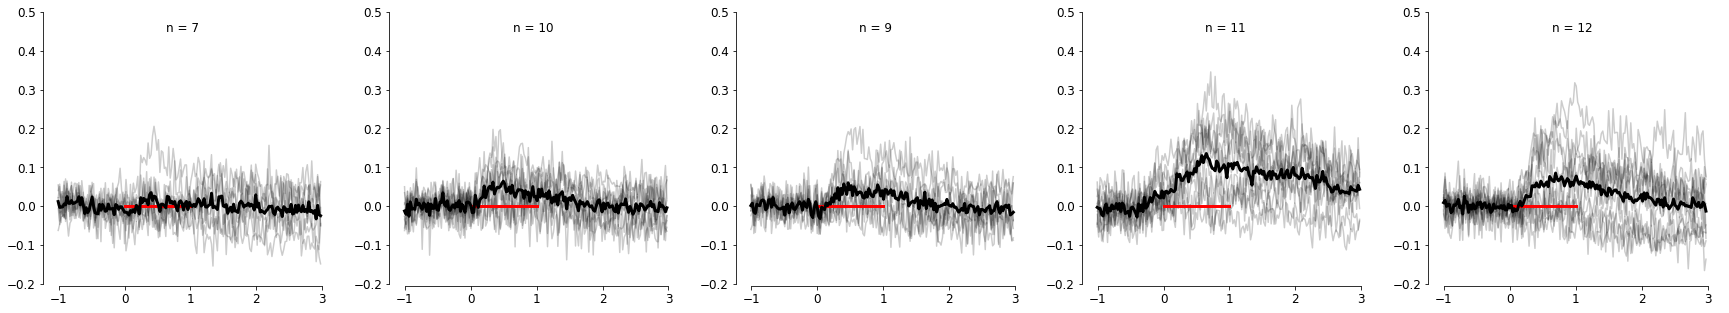

In [1476]:
pl.figure(figsize=(30,5))
dfmats = {}
pidx = 1
for morphlevel in [1, 6, 11, 16, 20]:
    currax = pl.subplot(1,5,pidx)
    
    dfmat = []
    curr_trials = list(set(DF[DF['morphlevel'] == morphlevel]['trial']))
    excl = list(set(EXCLUDE['morph%i' % morphlevel])) #excluded_trials['morph%i' % morphlevel]
    curr_ntrials = len(curr_trials) - len(excl)
    
    print "Exclude %i of %i trials" % (len(excl), len(curr_trials))
    for trial in curr_trials:
        if trial in excl:
            continue
        df = DF[((DF['morphlevel']==morphlevel) & (DF['trial']==trial))]['df']
        currax.plot(tsecs, df, alpha=0.2, color='k')
        currax.plot([tsecs[first_on], tsecs[first_on]+nsecs_on], [0, 0], stimbar_color, linewidth=3, alpha=1)
        dfmat.append(df)
            
    pl.plot(tsecs,np.mean(dfmat, axis=0), color='k', linewidth=3)
    currax.set_ylim([-0.2, 0.5])
    dfmats['morph%i' % morphlevel] = np.array(dfmat)
    
    currax.annotate("n = %i" % curr_ntrials, xy=psth.get_axis_limits(currax, xscale=0.2, yscale=0.9))

    sns.despine(offset=2, trim=True)
    pidx += 1

In [1477]:
for k in dfmats.keys():
    print k, dfmats[k].shape

morph1 (8, 179)
morph20 (12, 179)
morph11 (9, 179)
morph16 (11, 179)
morph6 (10, 179)


In [1478]:
zscores = {}
for mkey in sorted(dfmats.keys(), key=natural_keys):
    mean_on = np.array([np.mean(dfmats[mkey][t, first_on:first_on+nframes_on]) for t in range(dfmats[mkey].shape[0])])
    std_baseline = np.array([np.std(dfmats[mkey][t, 0:first_on]) for t in range(dfmats[mkey].shape[0])])
    trial_zscore = mean_on / std_baseline
    zscores[mkey] = trial_zscore

[1, 6, 11, 16, 20]
[0.14292071626700464, 1.048430835401587, 0.8799204074888496, 2.102618150488369, 1.2395790156227033]


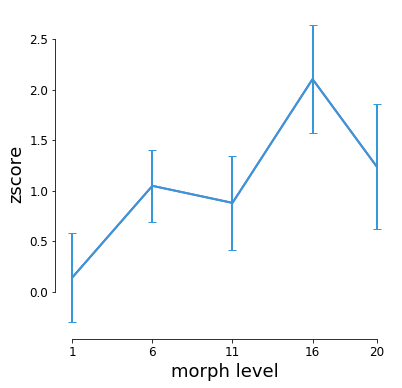

In [1479]:
fig, ax = pl.subplots(nrows=1, ncols=1, sharex=False, squeeze=True, figsize=(6,6))

morphlevel_list = [1, 6, 11, 16, 20] #sorted(zscores.keys(), key=natural_keys) #[1, 6, 11, 16, 20]
mean_zscores = [np.mean(zscores[mkey]) for mkey in sorted(zscores.keys(), key=natural_keys)]

#sns.pointplot(x=morphlevel_list, y=mean_zscores, ci=None, join=True, markers='', scale=2, ax=ax, legend_out=True)

#morphlevel_list = sorted(zscores.keys(), key=natural_keys) #[1, 6, 11, 16, 20]
#mean_zscores = [np.mean(zscores[mkey]) for mkey in sorted(zscores.keys(), key=natural_keys)]
sem_yerr = [stats.sem(zscores[mkey]) for mkey in sorted(zscores.keys(), key=natural_keys)]
pl.plot(morphlevel_list, mean_zscores, linewidth=2)
pl.errorbar(x=morphlevel_list, y=mean_zscores, yerr=sem_yerr, linewidth=2, capsize=4)
print morphlevel_list
print mean_zscores
# h1.set(
#  xticks=morph_levels) 
pl.xticks(morphlevel_list, morphlevel_list)
pl.ylabel('zscore', fontsize=18)
pl.xlabel('morph level', fontsize=18)
pl.rcParams.update({'font.size': 12})


sns.despine(offset=2, trim=True)

<Container object of 3 artists>

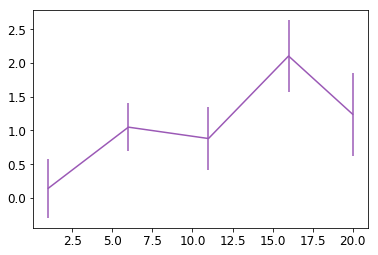

In [1480]:
pl.errorbar(x=morphlevel_list, y=mean_zscores, yerr=sem_yerr)


In [198]:
excluded_trials = {}
excluded_trials['morph20'] = []
excluded_trials['morph16'] = ['trial00122', 'trial00046', 'trial00065', 'trial00089']
excluded_trials['morph11'] = []
excluded_trials['morph6'] = ['trial00074', 'trial00058','trial00008', 'trial00072', 'trial00106']
excluded_trials['morph1'] = []

In [199]:
df = morph_df[((morph_df['morphlevel']==morphlevel) & (morph_df['trial']==trial))]['df']
df.shape

(0,)

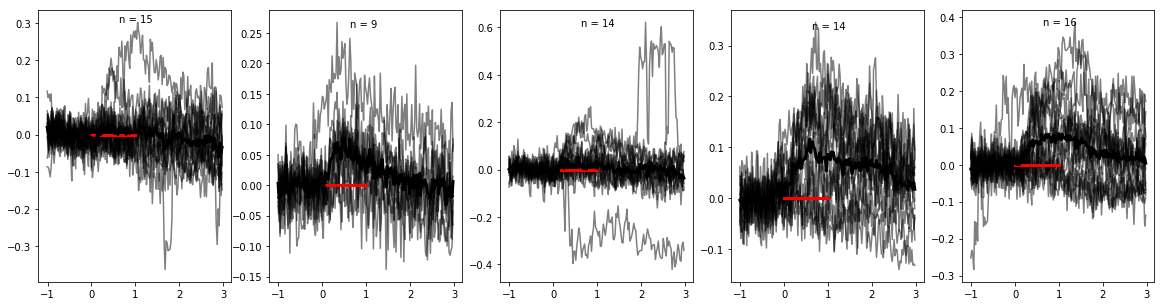

In [548]:
pl.figure(figsize=(20,5))
dfmats = {}
pidx = 1
for morphlevel in [1, 6, 11, 16, 20]:
    currax = pl.subplot(1,5,pidx)
    dfmat = []
    curr_trials = list(set(morph_df[morph_df['morphlevel'] == morphlevel]['trial']))
    excl= EXCLUDE['morph%i' % morphlevel] #excluded_trials['morph%i' % morphlevel]
    
    for trial in curr_trials:
        if trial in excl:
            continue
        df = morph_df[((morph_df['morphlevel']==morphlevel) & (morph_df['trial']==trial))]['df']
        currax.plot(tsecs, df, alpha=0.5, color='k')
        currax.plot([tsecs[first_on], tsecs[first_on]+nsecs_on], [0, 0], stimbar_color, linewidth=3, alpha=1)
        dfmat.append(df)
        
    curr_ntrials = len(curr_trials) - len(excl)
    currax.annotate("n = %i" % curr_ntrials, xy=psth.get_axis_limits(currax, xscale=0.2, yscale=0.9))
        
    pl.plot(tsecs,np.mean(dfmat, axis=0), color='k', linewidth=3)
    
    dfmats['morph%i' % morphlevel] = np.array(dfmat)
    
    pidx += 1

In [207]:
roi_list = sorted(DATA.keys(), key=natural_keys)
first_on = list(set(DATA[roi_list[0]]['first_on']))[0]
nframes_on = int(round(list(set(DATA[roi_list[0]]['nframes_on']))[0]))
print "first on:", first_on
print "nframes on:", nframes_on

first on: 45
nframes on: 45


In [214]:
zscores = {}
for mkey in sorted(dfmats.keys(), key=natural_keys):
    mean_on = np.array([np.mean(dfmats[mkey][t, first_on:first_on+nframes_on]) for t in range(dfmats[mkey].shape[0])])
    std_baseline = np.array([np.std(dfmats[mkey][t, 0:first_on]) for t in range(dfmats[mkey].shape[0])])
    trial_zscore = mean_on / std_baseline
    zscores[mkey] = trial_zscore

In [217]:
from scipy import stats


<Container object of 3 artists>

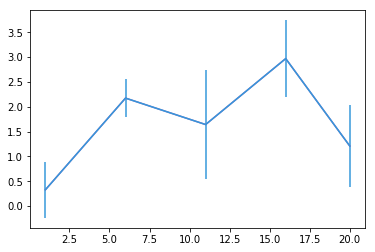

In [220]:
morphlevel_list = [1, 6, 11, 16, 20]
mean_zscores = [np.mean(zscores[mkey]) for mkey in sorted(zscores.keys(), key=natural_keys)]
sem_yerr = [stats.sem(zscores[mkey]) for mkey in sorted(zscores.keys(), key=natural_keys)]
pl.plot(morphlevel_list, mean_zscores)
pl.errorbar(morphlevel_list, mean_zscores, yerr=sem_yerr)

In [170]:
morphlevel = 6
curr_trials = list(set(morph_df[morph_df['morphlevel'] == morphlevel]['trial']))
curr_trials

[u'trial00058',
 u'trial00074',
 u'trial00051',
 u'trial00087',
 u'trial00008',
 u'trial00072',
 u'trial00095',
 u'trial00106']

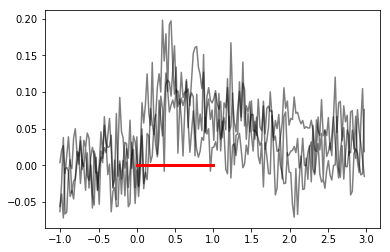

In [188]:
trial = 'trial00065'
excl = ['trial00074', 'trial00058','trial00008', 'trial00072', 'trial00106']
for trial in curr_trials:
    if trial in excl:
        continue
    df = morph_df[((morph_df['morphlevel']==morphlevel) & (morph_df['trial']==trial))]['df']
    pl.plot(tsecs, df, alpha=0.5, color='k')
    pl.plot([tsecs[first_on], tsecs[first_on]+nsecs_on], [0, 0], stimbar_color, linewidth=3, alpha=1)
    dfmat.append(df)

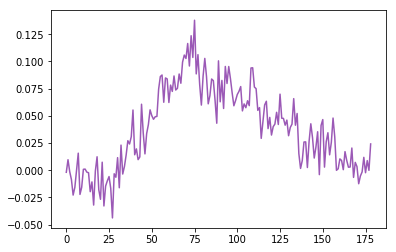

In [139]:
pl.plot(np.mean(dfmat, axis=0))